In [1]:
# Notebook: Chars74K ANPR - EDA & Training
# Code in English, comments in Spanish

import os
import csv
import random
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T


In [2]:
import os
import shutil

BASE_DIR = "."  # donde está la carpeta English
SRC_DIR = os.path.join(BASE_DIR, "English", "Fnt")
DST_DIR = os.path.join(BASE_DIR, "English", "Fnt_ANPR")

print("SRC_DIR:", SRC_DIR, "exists:", os.path.isdir(SRC_DIR))
print("DST_DIR:", DST_DIR, "exists:", os.path.isdir(DST_DIR))

os.makedirs(DST_DIR, exist_ok=True)

valid_samples = list(range(1, 37))  # 1..36

for s in valid_samples:
    sample_name = f"Sample{s:03d}"
    src = os.path.join(SRC_DIR, sample_name)
    dst = os.path.join(DST_DIR, sample_name)

    print(f"Checking {sample_name}: src exists? {os.path.isdir(src)}")

    if not os.path.isdir(src):
        print(f"  WARNING: {src} does not exist, skipping.")
        continue

    if not os.path.exists(dst):
        print(f"  Copying {sample_name} -> {dst}")
        shutil.copytree(src, dst)
    else:
        print(f"  {sample_name} already exists in Fnt_ANPR, skipping.")

print("\nDST_DIR content:", os.listdir(DST_DIR)[:10])


SRC_DIR: ./English/Fnt exists: True
DST_DIR: ./English/Fnt_ANPR exists: True
Checking Sample001: src exists? True
  Sample001 already exists in Fnt_ANPR, skipping.
Checking Sample002: src exists? True
  Sample002 already exists in Fnt_ANPR, skipping.
Checking Sample003: src exists? True
  Sample003 already exists in Fnt_ANPR, skipping.
Checking Sample004: src exists? True
  Sample004 already exists in Fnt_ANPR, skipping.
Checking Sample005: src exists? True
  Sample005 already exists in Fnt_ANPR, skipping.
Checking Sample006: src exists? True
  Sample006 already exists in Fnt_ANPR, skipping.
Checking Sample007: src exists? True
  Sample007 already exists in Fnt_ANPR, skipping.
Checking Sample008: src exists? True
  Sample008 already exists in Fnt_ANPR, skipping.
Checking Sample009: src exists? True
  Sample009 already exists in Fnt_ANPR, skipping.
Checking Sample010: src exists? True
  Sample010 already exists in Fnt_ANPR, skipping.
Checking Sample011: src exists? True
  Sample011 alre

In [3]:
import os
import csv
import string

DST_DIR = "./English/Fnt_ANPR"
CSV_PATH = "./chars74k_anpr_labels.csv"

# Mapping SampleXXX -> char
sample_to_char = {}

digits = "0123456789"
uppercase = string.ascii_uppercase  # 'A'..'Z'

# Digits: Sample001..Sample010 -> '0'..'9'
for i, d in enumerate(digits, start=1):  # 1..10
    sample_to_char[f"Sample{i:03d}"] = d

# Uppercase: Sample011..Sample036 -> 'A'..'Z'
for offset, ch in enumerate(uppercase, start=11):  # 11..36
    sample_to_char[f"Sample{offset:03d}"] = ch

# Mapping char -> label (0..35)
char_to_label = {}
for idx, d in enumerate(digits):
    char_to_label[d] = idx  # 0..9

for idx, ch in enumerate(uppercase, start=10):
    char_to_label[ch] = idx  # 10..35

rows = []

for sample_name in sorted(os.listdir(DST_DIR)):
    sample_path = os.path.join(DST_DIR, sample_name)
    if not os.path.isdir(sample_path):
        continue

    if sample_name not in sample_to_char:
        # por si se cuela algo fuera de Sample001..036
        continue

    char = sample_to_char[sample_name]
    label = char_to_label[char]

    for fname in os.listdir(sample_path):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
            continue

        rel_path = os.path.join(sample_name, fname)
        rows.append((rel_path, char, label))

print(f"Total samples found: {len(rows)}")

with open(CSV_PATH, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["rel_path", "char", "label"])
    writer.writerows(rows)

print(f"CSV saved to {CSV_PATH}")


Total samples found: 36576
CSV saved to ./chars74k_anpr_labels.csv


In [4]:
# Recorrer Fnt_ANPR y generar CSV

rows = []

for sample_name in sorted(os.listdir(DST_DIR)):
    sample_path = os.path.join(DST_DIR, sample_name)
    if not os.path.isdir(sample_path):
        continue

    if sample_name not in sample_to_char:
        # Ignora cualquier carpeta fuera del rango 001..036
        continue

    char = sample_to_char[sample_name]
    label = char_to_label[char]

    for fname in os.listdir(sample_path):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
            continue

        rel_path = os.path.join(sample_name, fname)
        rows.append((rel_path, char, label))

print(f"Total samples found: {len(rows)}")

with open(CSV_PATH, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["rel_path", "char", "label"])
    writer.writerows(rows)

print(f"CSV saved to {CSV_PATH}")


Total samples found: 36576
CSV saved to ./chars74k_anpr_labels.csv


In [5]:
import pandas as pd

df = pd.read_csv("./chars74k_anpr_labels.csv")
print(df.shape)
df.head()


(36576, 3)


,rel_path,char,label
0,Sample001/img001-00006.png,0,0
1,Sample001/img001-00007.png,0,0
2,Sample001/img001-00008.png,0,0
3,Sample001/img001-00009.png,0,0
4,Sample001/img001-00010.png,0,0


# EDA

In [6]:
import os
import random
from collections import Counter

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

CSV_PATH = "./chars74k_anpr_labels.csv"
IMG_ROOT = "./English/Fnt_ANPR"

df = pd.read_csv(CSV_PATH)
df.head()


,rel_path,char,label
0,Sample001/img001-00006.png,0,0
1,Sample001/img001-00007.png,0,0
2,Sample001/img001-00008.png,0,0
3,Sample001/img001-00009.png,0,0
4,Sample001/img001-00010.png,0,0


char
0    1016
1    1016
2    1016
3    1016
4    1016
5    1016
6    1016
7    1016
8    1016
9    1016
A    1016
B    1016
C    1016
D    1016
E    1016
F    1016
G    1016
H    1016
I    1016
J    1016
K    1016
L    1016
M    1016
N    1016
O    1016
P    1016
Q    1016
R    1016
S    1016
T    1016
U    1016
V    1016
W    1016
X    1016
Y    1016
Z    1016
Name: count, dtype: int64


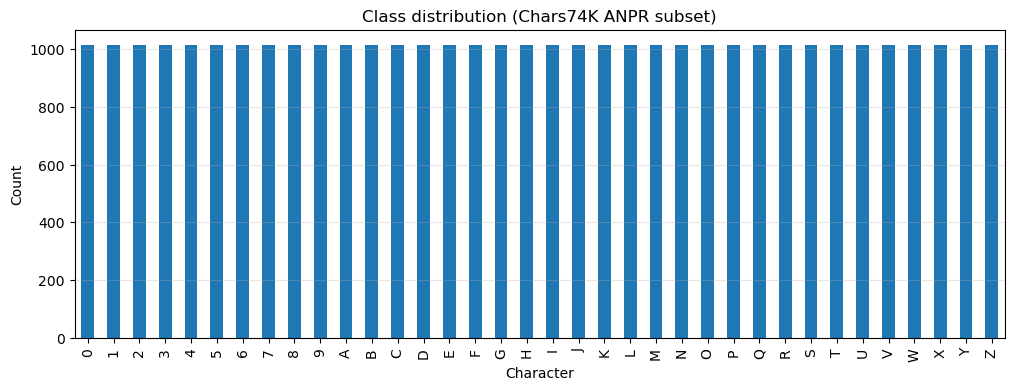

In [7]:
# Distribución de clases por carácter

class_counts = df["char"].value_counts().sort_index()
print(class_counts)

plt.figure(figsize=(12, 4))
class_counts.plot(kind="bar")
plt.title("Class distribution (Chars74K ANPR subset)")
plt.xlabel("Character")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()


In [8]:
# Comprobar tamaños de imagen (muestreo rápido)

sizes = []

for i in range(0, min(1000, len(df))):
    row = df.iloc[i]
    img_path = os.path.join(IMG_ROOT, row["rel_path"])
    img = Image.open(img_path)
    sizes.append(img.size)

sizes_counter = Counter(sizes)
print("Image size distribution (width, height) -> count:")
for k, v in sizes_counter.items():
    print(k, "->", v)


Image size distribution (width, height) -> count:
(128, 128) -> 1000


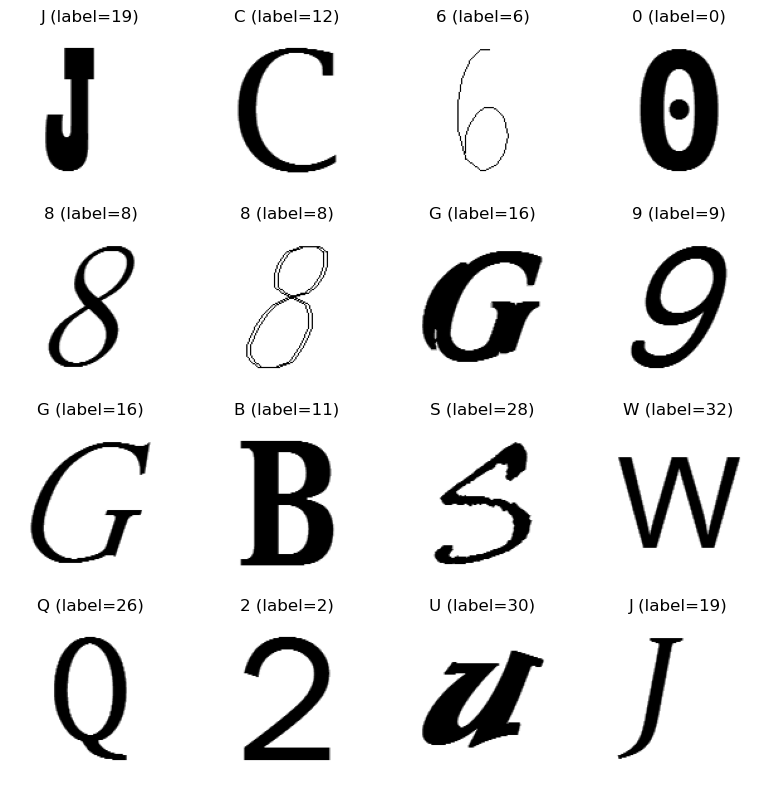

In [9]:
# Ver algunas muestras aleatorias

def show_random_samples(n=16):
    plt.figure(figsize=(8, 8))
    indices = random.sample(range(len(df)), n)
    for i, idx in enumerate(indices):
        row = df.iloc[idx]
        img_path = os.path.join(IMG_ROOT, row["rel_path"])
        img = Image.open(img_path).convert("L")

        plt.subplot(4, 4, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"{row['char']} (label={row['label']})")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_random_samples(16)


# TRAIN

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

class Chars74KANPRDataset(Dataset):
    # Dataset basado en el CSV que has generado
    def __init__(self, csv_path, root_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row["rel_path"])
        img = Image.open(img_path).convert("L")  # grayscale

        if self.transform:
            img = self.transform(img)

        label = int(row["label"])
        return img, label

# Transform: redimensionar a 32x32 y normalizar a [-1,1]
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

dataset = Chars74KANPRDataset(
    csv_path=CSV_PATH,
    root_dir=IMG_ROOT,
    transform=transform,
)

len(dataset)


36576

In [11]:
# Split train / val / test (70 / 15 / 15)

n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test])

batch_size = 128  # puedes bajar a 64 si vas justo de RAM

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")


Train: 25603, Val: 5486, Test: 5487


In [12]:
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    # CNN pequeñita para 36 clases (0–9, A–Z)
    def __init__(self, num_classes=36):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32 -> 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16 -> 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8 -> 4x4
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SimpleCNN(num_classes=36).to(device)


Using device: cpu


In [13]:
def accuracy_from_logits(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10  # para probar, puedes empezar con 5

for epoch in range(1, num_epochs + 1):
    # Training
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    train_batches = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy_from_logits(outputs, labels)
        train_batches += 1

    train_loss /= train_batches
    train_acc  /= train_batches

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_batches = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += accuracy_from_logits(outputs, labels)
            val_batches += 1

    val_loss /= val_batches
    val_acc  /= val_batches

    print(f"Epoch {epoch:02d}/{num_epochs} "
          f"- Train loss: {train_loss:.4f}, acc: {train_acc:.4f} "
          f"- Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")


Epoch 01/10 - Train loss: 0.9639, acc: 0.7391 - Val loss: 0.3131, acc: 0.9152
Epoch 02/10 - Train loss: 0.3031, acc: 0.9136 - Val loss: 0.2449, acc: 0.9306
Epoch 03/10 - Train loss: 0.2171, acc: 0.9356 - Val loss: 0.1751, acc: 0.9504
Epoch 04/10 - Train loss: 0.1699, acc: 0.9475 - Val loss: 0.1573, acc: 0.9510
Epoch 05/10 - Train loss: 0.1317, acc: 0.9577 - Val loss: 0.1344, acc: 0.9646
Epoch 06/10 - Train loss: 0.1194, acc: 0.9601 - Val loss: 0.1345, acc: 0.9577
Epoch 07/10 - Train loss: 0.1195, acc: 0.9612 - Val loss: 0.1246, acc: 0.9603
Epoch 08/10 - Train loss: 0.0883, acc: 0.9706 - Val loss: 0.1009, acc: 0.9683
Epoch 09/10 - Train loss: 0.0833, acc: 0.9719 - Val loss: 0.1091, acc: 0.9706
Epoch 10/10 - Train loss: 0.0791, acc: 0.9730 - Val loss: 0.0904, acc: 0.9743


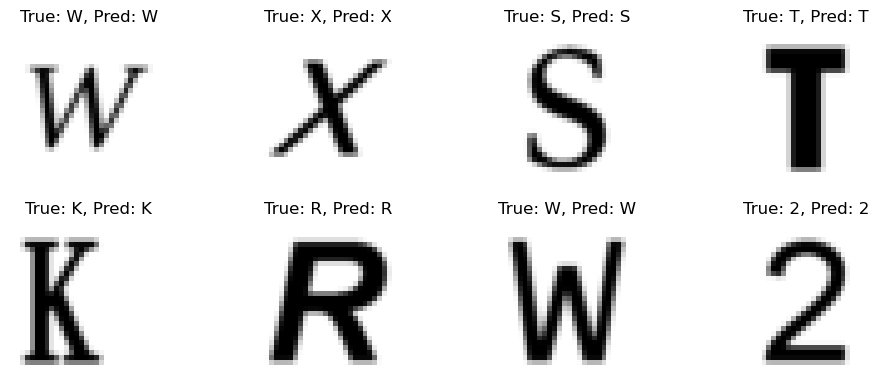

In [14]:
# Mapa inverso de label -> char, usando el CSV

char_to_label = {c: int(l) for c, l in zip(df["char"], df["label"])}
# Ojo: lo anterior puede duplicar; mejor reconstruir bien:
import string

digits = "0123456789"
uppercase = string.ascii_uppercase

char_to_label = {}
for idx, d in enumerate(digits):
    char_to_label[d] = idx
for idx, ch in enumerate(uppercase, start=10):
    char_to_label[ch] = idx

label_to_char = {v: k for k, v in char_to_label.items()}

import matplotlib.pyplot as plt
import random

model.eval()
plt.figure(figsize=(10, 4))

indices = random.sample(range(len(test_set)), 8)

for i, idx in enumerate(indices):
    img, label = test_set[idx]
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        pred_label = torch.argmax(output, dim=1).item()

    img_np = img.squeeze(0).numpy()
    img_np = (img_np * 0.5 + 0.5)  # desnormalizar a [0,1]

    plt.subplot(2, 4, i + 1)
    plt.imshow(img_np, cmap="gray")
    plt.title(f"True: {label_to_char[label]}, Pred: {label_to_char[pred_label]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# PLATE

(np.float64(-0.5), np.float64(2047.5), np.float64(1535.5), np.float64(-0.5))

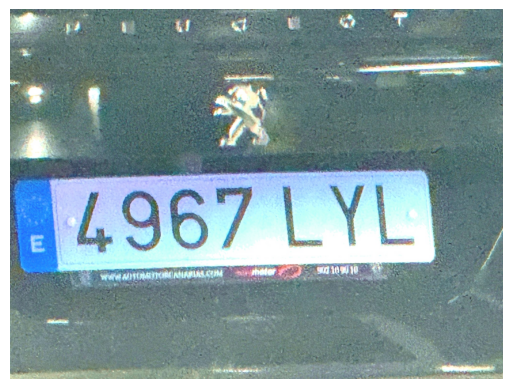

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

plate_img = Image.open("test_plate_001.jpg")
plt.imshow(plate_img)
plt.axis("off")


In [16]:
pip install ultralytics


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load YOLO model (single class: 'plate')
yolo_model = YOLO("license_plate_detector.pt")  # TODO: reemplaza por el path real a tus pesos


In [18]:
def detect_plate_yolo(img_path, conf_threshold=0.4, debug=False):
    """
    Detect license plate bounding box using a YOLO model.
    Returns (plate_roi_bgr, (x1, y1, x2, y2)) or None if not found.
    """
    # Read image with OpenCV
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        raise ValueError(f"Could not read image: {img_path}")

    # Run YOLO inference (CPU by default if no GPU)
    results = yolo_model(img_bgr)

    # results[0] is first image result
    boxes = results[0].boxes

    if boxes is None or len(boxes) == 0:
        return None

    # Filter by confidence
    candidates = []
    for box in boxes:
        conf = float(box.conf[0])
        if conf < conf_threshold:
            continue

        x1, y1, x2, y2 = box.xyxy[0].tolist()
        candidates.append((conf, int(x1), int(y1), int(x2), int(y2)))

    if not candidates:
        return None

    # Pick box with highest confidence
    candidates.sort(key=lambda x: x[0], reverse=True)
    best_conf, x1, y1, x2, y2 = candidates[0]

    plate_roi = img_bgr[y1:y2, x1:x2]

    if debug:
        img_debug = img_bgr.copy()
        cv2.rectangle(img_debug, (x1, y1), (x2, y2), (0, 255, 0), 2)
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img_debug, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected bbox (conf={best_conf:.2f})")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(plate_roi, cv2.COLOR_BGR2RGB))
        plt.title("Plate ROI")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    return plate_roi, (x1, y1, x2, y2)


In [19]:
import numpy as np
import torchvision.transforms as T
from PIL import Image
import string
import torch

# --- mapeos label<->char como antes ---
digits = "0123456789"
uppercase = string.ascii_uppercase

char_to_label = {d:i for i,d in enumerate(digits)}
for i,ch in enumerate(uppercase, start=10):
    char_to_label[ch] = i
label_to_char = {v:k for k,v in char_to_label.items()}

# --- transform para tu CNN ---
transform_char = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

def prepare_char(img_array):
    pil = Image.fromarray(img_array).convert("L")
    return transform_char(pil).unsqueeze(0)  # [1,1,32,32]

def read_plate_from_vehicle(img_path, conf_threshold=0.4, debug=False):
    """
    Full pipeline:
      1) YOLO detects plate ROI
      2) Segment characters (OpenCV)
      3) Run CNN OCR on each char
      4) Return predicted plate string
    """
    # 1) Detect plate with YOLO
    res = detect_plate_yolo(img_path, conf_threshold=conf_threshold, debug=debug)
    if res is None:
        print("No plate detected by YOLO")
        return None

    plate_roi_bgr, bbox = res
    plate_gray = cv2.cvtColor(plate_roi_bgr, cv2.COLOR_BGR2GRAY)

    # 2) Binarize and find char contours
    _, thresh = cv2.threshold(
        plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    inv = 255 - thresh

    contours, _ = cv2.findContours(
        inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    h_img, w_img = inv.shape
    char_regions = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # simple heuristics for characters inside plate ROI
        if h > 0.4 * h_img and h < 0.95 * h_img and w > 5 and w < 0.5 * w_img:
            char_regions.append((x, y, w, h))

    if not char_regions:
        print("No characters detected inside plate ROI")
        return None

    # Sort by x for left-to-right order
    char_regions = sorted(char_regions, key=lambda r: r[0])

    if debug:
        plt.figure(figsize=(10, 3))
        for i, (x, y, w, h) in enumerate(char_regions):
            char_img = plate_gray[y:y+h, x:x+w]
            plt.subplot(1, len(char_regions), i+1)
            plt.imshow(char_img, cmap="gray")
            plt.axis("off")
        plt.suptitle("Char crops from plate ROI")
        plt.show()

    # 3) Run CNN OCR
    model.eval()
    predicted_chars = []

    for (x, y, w, h) in char_regions:
        char_img = plate_gray[y:y+h, x:x+w]
        tensor = prepare_char(char_img).to(device)

        with torch.no_grad():
            out = model(tensor)
            pred_label = torch.argmax(out, dim=1).item()

        predicted_chars.append(label_to_char[pred_label])

    plate_str = "".join(predicted_chars)
    return plate_str



0: 640x480 1 license_plate, 61.1ms
Speed: 1.4ms preprocess, 61.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


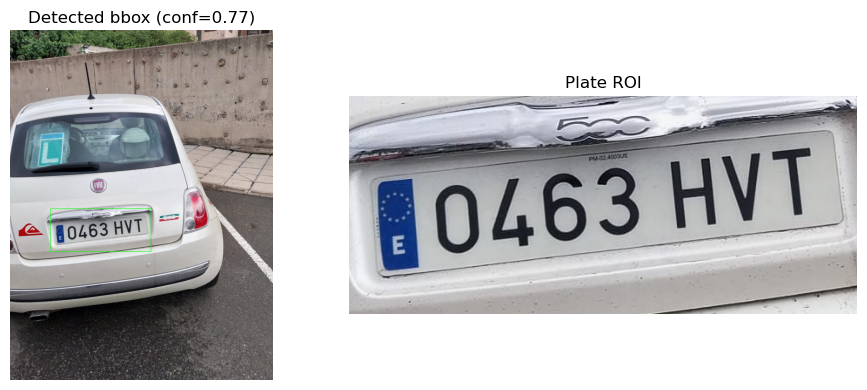

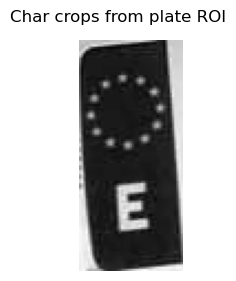

Predicted plate: R


In [35]:
pred = read_plate_from_vehicle("test_plate_002.jpeg", conf_threshold=0.4, debug=True)
print("Predicted plate:", pred)


In [71]:
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as T

transform_base = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

def prepare_char_normalized(char_gray: np.ndarray):
    """
    Normaliza un recorte de carácter para que se parezca a Chars74K:
      - binariza
      - asegura texto negro sobre fondo blanco
      - recorta al bounding box real
      - reescala manteniendo aspecto
      - centra y rellena a 32x32
    Devuelve un tensor [1,1,32,32]
    """
    # 1) Binarizar
    _, bin_img = cv2.threshold(
        char_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Asegurar carácter negro sobre fondo blanco
    white = np.sum(bin_img == 255)
    black = np.sum(bin_img == 0)
    if black > white:
        bin_img = 255 - bin_img

    # 2) Bounding box del carácter (píxeles no blancos)
    coords = cv2.findNonZero(255 - bin_img)
    if coords is None:
        crop = bin_img
    else:
        x, y, w, h = cv2.boundingRect(coords)
        crop = bin_img[y:y+h, x:x+w]

    # 3) Reescalar manteniendo aspecto (lado máx ~24 px)
    target_size = 32
    ch, cw = crop.shape
    scale = 24 / max(ch, cw)
    new_w = max(1, int(cw * scale))
    new_h = max(1, int(ch * scale))
    resized = cv2.resize(crop, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # 4) Lienzo blanco 32x32 centrando el carácter
    canvas = np.ones((target_size, target_size), dtype=np.uint8) * 255
    y_off = (target_size - new_h) // 2
    x_off = (target_size - new_w) // 2
    canvas[y_off:y_off+new_h, x_off:x_off+new_w] = resized

    # 5) A tensor
    pil = Image.fromarray(canvas).convert("L")
    tensor = transform_base(pil).unsqueeze(0)  # [1,1,32,32]
    return tensor


In [72]:
import matplotlib.pyplot as plt

def read_plate_from_roi(plate_gray, debug=False):
    """
    Lee una matrícula a partir de una ROI en escala de grises (plate_gray).
    Hace:
      - binarización
      - segmentación de caracteres
      - normalización de cada carácter
      - OCR con el modelo CNN
    """
    # 1) Binarizar ROI
    _, thresh = cv2.threshold(
        plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    inv = 255 - thresh
    h_img, w_img = inv.shape

    contours, _ = cv2.findContours(
        inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    char_regions = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        aspect = w / float(h)

        # Heurísticas algo suaves para no perder letras
        if h < 0.3 * h_img or h > 0.95 * h_img:
            continue
        if w < 0.02 * w_img or w > 0.3 * w_img:
            continue

        char_regions.append((x, y, w, h))

    if not char_regions:
        print("No characters detected inside plate ROI")
        return None

    # Ordenar de izquierda a derecha
    char_regions = sorted(char_regions, key=lambda r: r[0])

    if debug:
        plt.figure(figsize=(10, 3))
        for i, (x, y, w, h) in enumerate(char_regions):
            char_img = plate_gray[y:y+h, x:x+w]
            plt.subplot(1, len(char_regions), i+1)
            plt.imshow(char_img, cmap="gray")
            plt.axis("off")
        plt.suptitle("Raw char crops from plate ROI")
        plt.tight_layout()
        plt.show()

    # 2) OCR carácter a carácter
    model.eval()
    predicted_chars = []

    for (x, y, w, h) in char_regions:
        char_img = plate_gray[y:y+h, x:x+w]
        tensor = prepare_char_normalized(char_img).to(device)

        with torch.no_grad():
            out = model(tensor)
            pred_label = torch.argmax(out, dim=1).item()

        predicted_chars.append(label_to_char.get(pred_label, "?"))

    return "".join(predicted_chars)


In [73]:
def read_plate_from_vehicle(img_path, conf_threshold=0.4, debug=False):
    """
    Pipeline completo desde imagen de vehículo:
      1) YOLO detecta la matrícula (ROI)
      2) read_plate_from_roi hace segmentación + OCR
    """
    # 1) Detect plate with YOLO
    res = detect_plate_yolo(img_path, conf_threshold=conf_threshold, debug=debug)
    if res is None:
        print("No plate detected by YOLO")
        return None

    plate_roi_bgr, bbox = res
    plate_gray = cv2.cvtColor(plate_roi_bgr, cv2.COLOR_BGR2GRAY)

    # 2) Leer matrícula a partir de la ROI ya recortada
    plate_str = read_plate_from_roi(plate_gray, debug=debug)
    return plate_str



0: 480x640 1 license_plate, 55.1ms
Speed: 1.2ms preprocess, 55.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


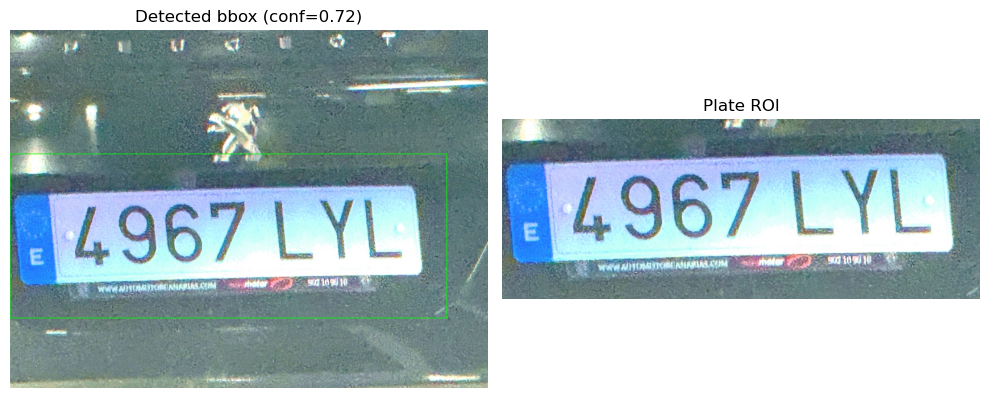

No characters detected inside plate ROI
Predicted plate: None


In [74]:
pred = read_plate_from_vehicle("test_plate_001.jpg", conf_threshold=0.4, debug=True)
print("Predicted plate:", pred)

In [75]:
def normalize_plate_roi(plate_gray):
    """
    Normaliza la ROI de la matrícula:
      - Si es pequeña, la escala hacia arriba.
      - Recorta solo la banda central vertical para quedarnos con la línea de texto.
    """
    h, w = plate_gray.shape

    # 1) Escalar si la placa es pequeña
    max_side = max(h, w)
    if max_side < 200:  # umbral ajustable
        scale = 200 / max_side
        plate_gray = cv2.resize(
            plate_gray, None,
            fx=scale, fy=scale,
            interpolation=cv2.INTER_CUBIC
        )
        h, w = plate_gray.shape

    # 2) Recortar solo banda central vertical (quitar bordes arriba/abajo)
    y1 = int(0.2 * h)
    y2 = int(0.8 * h)
    plate_gray = plate_gray[y1:y2, :]

    return plate_gray


In [142]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def segment_char_regions(plate_gray, debug=False):
    """
    Segment characters inside a license-plate ROI using connected components.

    Steps:
      1) Resize plate ROI to a fixed width (e.g., 300 px) -> resolution independent.
      2) Binarize (Otsu), invert so text is white.
      3) Connected components -> candidate blobs.
      4) Filter blobs by relative height/width/area (in the *normalized* space).
      5) Sort left-to-right and rescale boxes back to original plate_gray coordinates.

    Returns: list of (x, y, w, h) in the coordinates of the original plate_gray.
    """

    # --- 0) Normalize ROI width ---
    orig_h, orig_w = plate_gray.shape
    target_w = 300
    scale = target_w / float(orig_w)
    norm_w = target_w
    norm_h = int(round(orig_h * scale))

    plate_norm = cv2.resize(
        plate_gray, (norm_w, norm_h),
        interpolation=cv2.INTER_CUBIC
    )

    # --- 1) Binarize + invert ---
    _, thresh = cv2.threshold(
        plate_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    inv = 255 - thresh  # text -> white

    # --- 2) Connected components ---
    # connectedComponentsWithStats expects binary 0/255
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        (inv > 0).astype(np.uint8), connectivity=8
    )

    H, W = inv.shape

    # --- 3) Filter components by relative geometry ---
    regions_norm = []
    for label in range(1, num_labels):  # 0 is background
        x, y, w, h, area = stats[label]

        # descartar cosas muy pequeñas
        if area < 0.005 * (H * W):
            continue

        # descartar cosas demasiado grandes (tipo placa entera)
        if area > 0.3 * (H * W):
            continue

        # caracteres: altos pero no ocupan todo
        if h < 0.4 * H or h > 0.95 * H:
            continue

        # anchura razonable
        if w < 0.02 * W or w > 0.2 * W:
            continue

        regions_norm.append((x, y, w, h))

    if not regions_norm:
        if debug:
            print("No candidate regions after filtering.")
        return []

    # Ordenar por X
    regions_norm = sorted(regions_norm, key=lambda r: r[0])

    # --- 4) Opcional: fusionar regiones que se solapan mucho (fragmentos de un mismo char) ---
    merged_norm = []
    current = list(regions_norm[0])
    for (x, y, w, h) in regions_norm[1:]:
        cx, cy, cw, ch = current
        # solape horizontal fuerte -> fusionar
        overlap = min(cx+cw, x+w) - max(cx, x)
        if overlap > 0.5 * min(cw, w):
            nx = min(cx, x)
            ny = min(cy, y)
            nw = max(cx+cw, x+w) - nx
            nh = max(cy+ch, y+h) - ny
            current = [nx, ny, nw, nh]
        else:
            merged_norm.append(tuple(current))
            current = [x, y, w, h]
    merged_norm.append(tuple(current))

    # --- 5) Reescalar cajas a coordenadas originales ---
    regions = []
    inv_scale = 1.0 / scale
    for (x, y, w, h) in merged_norm:
        x0 = int(round(x * inv_scale))
        y0 = int(round(y * inv_scale))
        w0 = max(1, int(round(w * inv_scale)))
        h0 = max(1, int(round(h * inv_scale)))
        regions.append((x0, y0, w0, h0))

    # Orden final por X
    regions = sorted(regions, key=lambda r: r[0])

    # --- Debug ---
    if debug:
        print("Normalized plate size:", (norm_h, norm_w))
        print("Candidate regions (normalized):", merged_norm)
        print("Final regions (orig coords):", regions)

        # Mostrar cajas sobre la ROI original
        vis = cv2.cvtColor(plate_gray, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in regions:
            cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 255, 0), 1)

        plt.figure(figsize=(8, 3))
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.title("Char regions (CC + normalized)")
        plt.axis("off")
        plt.show()

        # Mostrar crops
        if regions:
            plt.figure(figsize=(10, 3))
            for i, (x, y, w, h) in enumerate(regions):
                char_img = plate_gray[y:y+h, x:x+w]
                plt.subplot(1, len(regions), i+1)
                plt.imshow(char_img, cmap="gray")
                plt.axis("off")
            plt.suptitle("Char crops")
            plt.tight_layout()
            plt.show()

    return regions


In [143]:
def read_plate_from_roi(plate_gray, debug=False):
    """
    1) normaliza ROI (si quieres mantener normalize_plate_roi)
    2) segmenta caracteres con proyección vertical
    3) normaliza cada carácter + CNN OCR
    """
    # opcional: si ya tienes normalize_plate_roi y te iba bien, puedes mantenerlo
    plate_gray = normalize_plate_roi(plate_gray)

    # 1) segmentación por proyección
    char_regions = segment_char_regions(plate_gray, debug=debug)
    if not char_regions:
        print("No characters detected inside plate ROI")
        return None

    # 2) OCR char a char
    model.eval()
    predicted_chars = []

    for (x, y, w, h) in char_regions:
        char_img = plate_gray[y:y+h, x:x+w]
        tensor = prepare_char_normalized(char_img).to(device)

        with torch.no_grad():
            out = model(tensor)
            pred_label = torch.argmax(out, dim=1).item()

        predicted_chars.append(label_to_char.get(pred_label, "?"))

    return "".join(predicted_chars)


In [144]:
def read_plate_from_vehicle(img_path, conf_threshold=0.4, debug=False):
    res = detect_plate_yolo(img_path, conf_threshold=conf_threshold, debug=debug)
    if res is None:
        print("No plate detected by YOLO")
        return None

    plate_roi_bgr, bbox = res
    plate_gray = cv2.cvtColor(plate_roi_bgr, cv2.COLOR_BGR2GRAY)
    return read_plate_from_roi(plate_gray, debug=debug)



0: 480x640 1 license_plate, 65.7ms
Speed: 1.3ms preprocess, 65.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


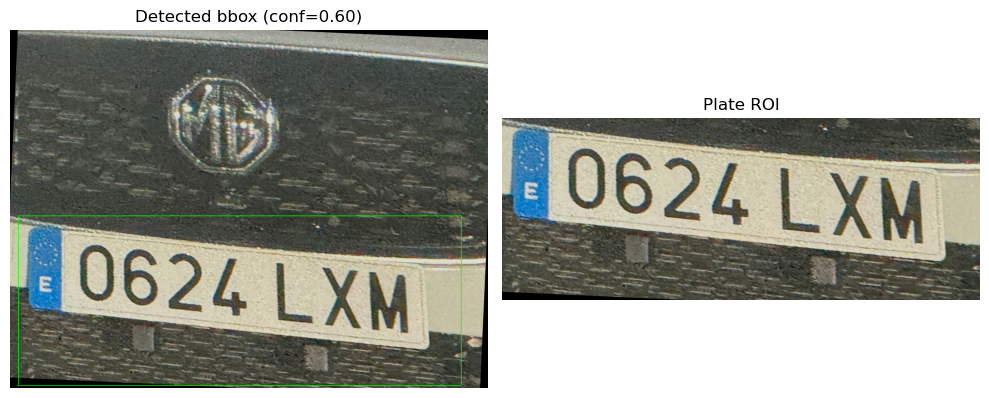

Normalized plate size: (69, 300)
Candidate regions (normalized): [(np.int32(42), np.int32(0), np.int32(23), np.int32(35)), (np.int32(71), np.int32(0), np.int32(23), np.int32(38)), (np.int32(102), np.int32(3), np.int32(22), np.int32(39)), (np.int32(132), np.int32(6), np.int32(23), np.int32(39)), (np.int32(175), np.int32(9), np.int32(25), np.int32(41)), (np.int32(206), np.int32(12), np.int32(26), np.int32(41)), (np.int32(238), np.int32(15), np.int32(26), np.int32(42))]
Final regions (orig coords): [(266, 0, 145, 221), (449, 0, 145, 240), (645, 19, 139, 247), (835, 38, 145, 247), (1107, 57, 158, 259), (1303, 76, 164, 259), (1505, 95, 164, 266)]


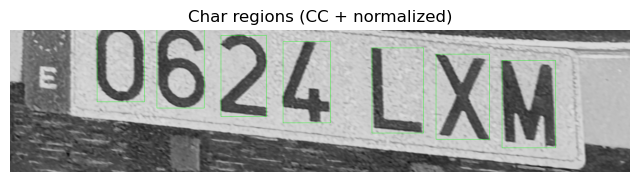

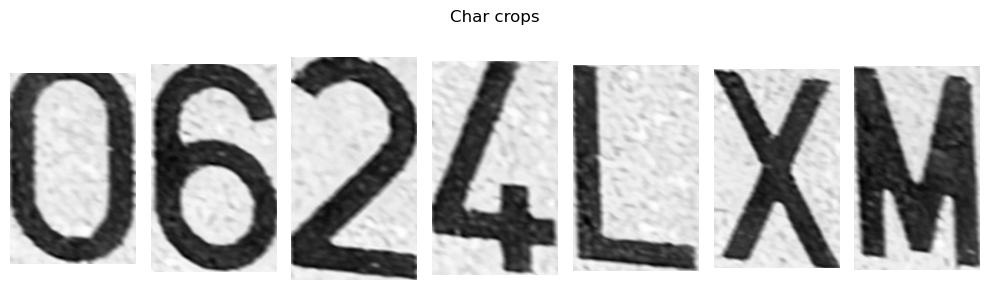

Predicted plate: 0624LXI


In [147]:
pred = read_plate_from_vehicle("test_plate_003.jpg", conf_threshold=0.4, debug=True)
print("Predicted plate:", pred)

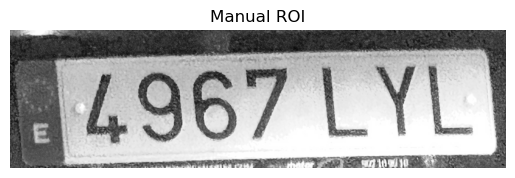

In [139]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("test_plate_001.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# EJEMPLO: recorte manual (ajusta x1,y1,x2,y2)
x1, y1, x2, y2 = 1, 600, 1800, 1100  # PON AQUÍ LOS TUYOS
plate_roi_bgr = img[y1:y2, x1:x2]
plate_gray = cv2.cvtColor(plate_roi_bgr, cv2.COLOR_BGR2GRAY)

plt.imshow(plate_gray, cmap="gray")
plt.title("Manual ROI")
plt.axis("off")
plt.show()


In [30]:
def segment_chars_debug(plate_gray):
    # 1) Binarizar la placa
    _, thresh = cv2.threshold(
        plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    inv = 255 - thresh

    h_img, w_img = inv.shape

    contours, _ = cv2.findContours(
        inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    print("Total contours found:", len(contours))

    char_regions = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        aspect = w / float(h)

        print(f"contour: x={x}, y={y}, w={w}, h={h}, area={area}, aspect={aspect:.2f}")

        # Heurísticas más suaves para no perder letras
        if h < 0.3 * h_img or h > 0.95 * h_img:
            continue
        if w < 0.02 * w_img or w > 0.3 * w_img:
            continue

        char_regions.append((x, y, w, h))

    # Ordenar por X
    char_regions = sorted(char_regions, key=lambda r: r[0])

    print("Char regions kept:", char_regions)

    # Visualizar recortes crudos
    if char_regions:
        plt.figure(figsize=(10, 3))
        for i, (x, y, w, h) in enumerate(char_regions):
            char_img = plate_gray[y:y+h, x:x+w]
            plt.subplot(1, len(char_regions), i+1)
            plt.imshow(char_img, cmap="gray")
            plt.axis("off")
        plt.suptitle("Raw char crops from plate ROI")
        plt.tight_layout()
        plt.show()
    else:
        print("No char regions kept.")

    return char_regions


Total contours found: 80
contour: x=1239, y=499, w=1, h=1, area=1, aspect=1.00
contour: x=997, y=499, w=1, h=1, area=1, aspect=1.00
contour: x=988, y=499, w=3, h=1, area=3, aspect=3.00
contour: x=601, y=499, w=1, h=1, area=1, aspect=1.00
contour: x=1013, y=498, w=2, h=2, area=4, aspect=1.00
contour: x=1435, y=497, w=6, h=3, area=18, aspect=2.00
contour: x=1284, y=497, w=28, h=3, area=84, aspect=9.33
contour: x=828, y=497, w=1, h=1, area=1, aspect=1.00
contour: x=628, y=497, w=4, h=3, area=12, aspect=1.33
contour: x=1384, y=496, w=11, h=4, area=44, aspect=2.75
contour: x=948, y=496, w=6, h=4, area=24, aspect=1.50
contour: x=844, y=496, w=3, h=3, area=9, aspect=1.00
contour: x=1514, y=495, w=8, h=5, area=40, aspect=1.60
contour: x=844, y=494, w=1, h=1, area=1, aspect=1.00
contour: x=822, y=494, w=5, h=5, area=25, aspect=1.00
contour: x=758, y=494, w=2, h=6, area=12, aspect=0.33
contour: x=667, y=494, w=4, h=6, area=24, aspect=0.67
contour: x=984, y=493, w=6, h=7, area=42, aspect=0.86
con

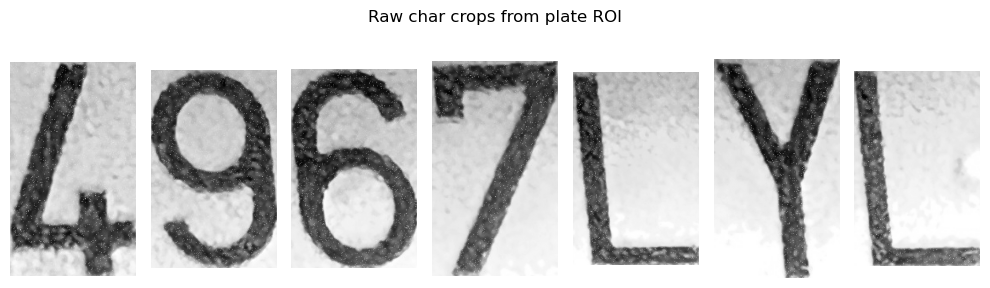

In [31]:
char_regions = segment_chars_debug(plate_gray)


In [123]:
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as T

# Transform base (ToTensor + Normalize)
transform_base = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

def prepare_char_normalized(char_gray: np.ndarray):
    """
    Normalize a character crop so it resembles Chars74K style:
      - binarize
      - ensure black text on white background
      - crop to character bounding box
      - resize keeping aspect ratio
      - center and pad to 32x32
    Returns a tensor [1,1,32,32]
    """
    # 1) Binarize
    _, bin_img = cv2.threshold(
        char_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Ensure text is darker (black letter over white background)
    white = np.sum(bin_img == 255)
    black = np.sum(bin_img == 0)
    if black > white:
        bin_img = 255 - bin_img

    # 2) Bounding box of the letter (non-white region)
    coords = cv2.findNonZero(255 - bin_img)
    if coords is None:
        crop = bin_img
    else:
        x, y, w, h = cv2.boundingRect(coords)
        crop = bin_img[y:y+h, x:x+w]

    # 3) Resize keeping aspect ratio to ~24 px on the longest side
    target_size = 32
    ch, cw = crop.shape
    scale = 24 / max(ch, cw)
    new_w = max(1, int(cw * scale))
    new_h = max(1, int(ch * scale))
    resized = cv2.resize(crop, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # 4) Center resized char into a white 32×32 canvas
    canvas = np.ones((target_size, target_size), dtype=np.uint8) * 255
    y_off = (target_size - new_h) // 2
    x_off = (target_size - new_w) // 2
    canvas[y_off:y_off+new_h, x_off:x_off+new_w] = resized

    # 5) To tensor
    pil = Image.fromarray(canvas).convert("L")
    tensor = transform_base(pil).unsqueeze(0)  # shape = [1,1,32,32]
    return tensor


def read_plate_from_roi(plate_gray, debug=False):
    # reutilizamos segment_chars_debug pero sin prints masivos:
    _, thresh = cv2.threshold(
        plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    inv = 255 - thresh
    h_img, w_img = inv.shape

    contours, _ = cv2.findContours(
        inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    char_regions = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        aspect = w / float(h)

        # mismas heurísticas suaves que antes
        if h < 0.3 * h_img or h > 0.95 * h_img:
            continue
        if w < 0.02 * w_img or w > 0.3 * w_img:
            continue

        char_regions.append((x, y, w, h))

    if not char_regions:
        print("No characters detected inside plate ROI")
        return None

    char_regions = sorted(char_regions, key=lambda r: r[0])

    if debug:
        plt.figure(figsize=(10, 3))
        for i, (x, y, w, h) in enumerate(char_regions):
            char_img = plate_gray[y:y+h, x:x+w]
            plt.subplot(1, len(char_regions), i+1)
            plt.imshow(char_img, cmap="gray")
            plt.axis("off")
        plt.suptitle("Raw char crops from plate ROI")
        plt.tight_layout()
        plt.show()

    # OCR con normalización de tamaño
    model.eval()
    predicted_chars = []

    for (x, y, w, h) in char_regions:
        char_img = plate_gray[y:y+h, x:x+w]
        tensor = prepare_char_normalized(char_img).to(device)

        # opcional: ver qué entra al modelo
        if debug:
            vis = tensor.squeeze(0).squeeze(0).cpu().numpy()
            vis = vis * 0.5 + 0.5
            plt.figure()
            plt.imshow(vis, cmap="gray")
            plt.title("Input to CNN")
            plt.axis("off")
            plt.show()

        with torch.no_grad():
            out = model(tensor)
            pred_label = torch.argmax(out, dim=1).item()

        predicted_chars.append(label_to_char.get(pred_label, "?"))

    return "".join(predicted_chars)



0: 480x640 1 license_plate, 57.3ms
Speed: 1.2ms preprocess, 57.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


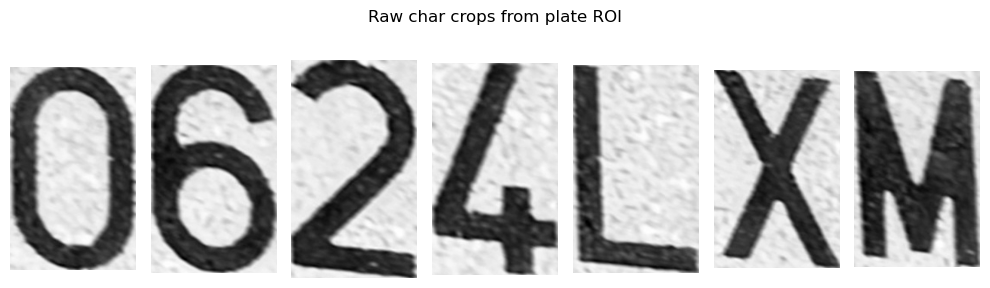

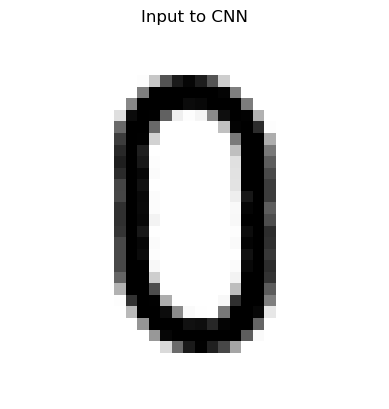

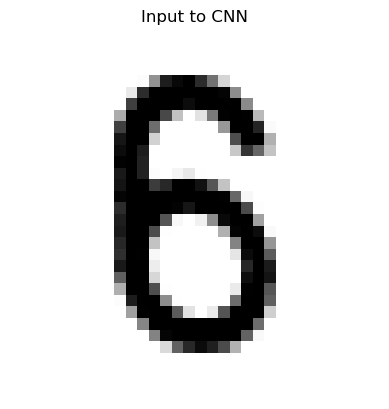

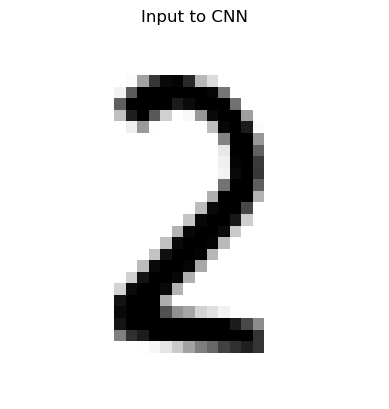

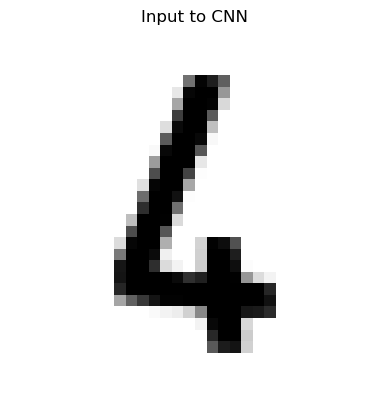

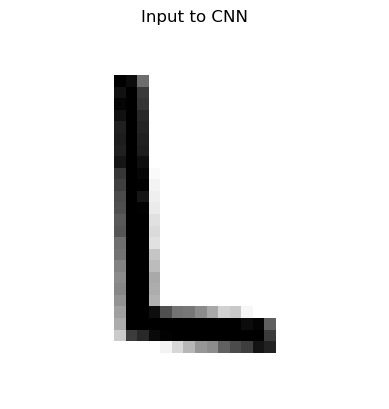

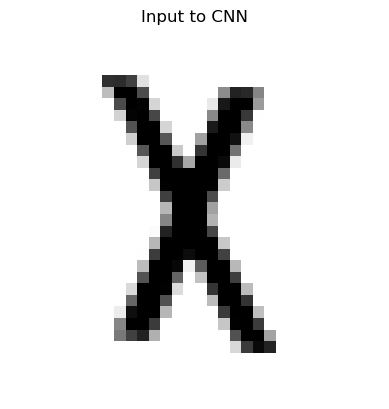

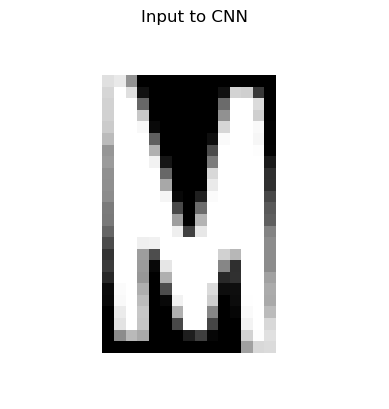

Predicted plate: 0624LXI


In [138]:
res = detect_plate_yolo("test_plate_003.jpg", conf_threshold=0.4, debug=False)
if res is None:
    print("No plate detected by YOLO")

plate_roi_bgr, bbox = res
plate_gray = cv2.cvtColor(plate_roi_bgr, cv2.COLOR_BGR2GRAY)
pred = read_plate_from_roi(plate_gray, debug=True)
print("Predicted plate:", pred)


   